In [31]:
import sys
import os
from pathlib import Path
import importlib

# The notebooks are in a 'notebooks' subfolder, so workspace root is one level up
# This works if notebook is in notebooks/ folder
workspace_root = Path("C:/00_Dev/daily_avg_pv_kpi_heatmap").resolve()

# Add workspace root to path so we can import from src
sys.path.insert(0, str(workspace_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import pvgis_pi_heatmap
importlib.reload(pvgis_pi_heatmap)  # Reload to pick up any changes

from src.pvgis_pi_heatmap import make_random_greece_meta, compute_pi_anomaly, short_label, parse_kwp_from_header

# Store workspace root for use in other cells
WORKSPACE_ROOT = workspace_root


In [32]:
DATA_DIR = WORKSPACE_ROOT / "data"
DATA_XLSX = DATA_DIR / "daily_energy.xlsx"
CACHE_DIR = WORKSPACE_ROOT / "pvgis_cache"

df = pd.read_excel(DATA_XLSX)

# Expect Timestamp column exactly
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["date"] = df["Timestamp"].dt.normalize()

park_cols = [c for c in df.columns if c not in ["Timestamp", "date"]]
daily = df.set_index("date")[park_cols].sort_index()

daily.head()


,[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh),[4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh),[4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh),[Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh),[Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh),"[Ntarali_Bonitas_0,45MW] PCC PCC active energy export (kWh)",[Ntarali_Concept_296KW] PCC PCC active energy export (kWh),[Ntarali_Concept_320KW] PCC PCC active energy export (kWh),[Ntarali_Concept_592KW] PCC PCC active energy export (kWh),[Ntarali_Konenergy_590KW] PCC PCC active energy export (kWh),...,[Solar Concept 276 KWp Likovouni] PCC PCC active energy export (kWh),[Solar Concept 3721 KWp Lexaina] PCC PCC active energy export (kWh),[Solar Datum 2910 KWp Lexaina] PCC PCC active energy export (kWh),[Solar Datum 864 KWp Darali] PCC PCC active energy export (kWh),[Solar Factory 494kWp Andravida] PCC PCC active energy export (kWh),[Spes Solaris 1527 KWp Darali] PCC PCC active energy export (kWh),[Spes Solaris 1986 KWp Lexaina] PCC PCC active energy export (kWh),[Spes Solaris 201 KWp Konizos] PCC PCC active energy export (kWh),[Spes Solaris 500 KWp Kavasila] PCC PCC active energy export (kWh),[Spes Solaris 805 KWp Konizos] PCC PCC active energy export (kWh)
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,661.701258,9238.85297,2688.141290,12422.34030,1256.222860,1368.437760,998.773363,1085.580560,1985.281570,NaN,...,1020.580780,6503.16485,6866.65910,2938.394500,1243.512860,4640.69780,4613.19648,675.929734,1374.611110,2813.551820
2024-01-02,232.492602,4364.17274,740.561842,6042.17857,582.902326,382.470766,271.836976,288.717779,558.257705,NaN,...,363.436834,3229.95644,3358.93415,824.771454,599.270967,1147.32135,2258.72972,190.054949,573.531389,800.890491
2024-01-03,479.375151,5824.89991,2398.988780,7570.04707,793.977828,1302.358890,860.002347,890.942226,1708.227890,NaN,...,731.829289,3912.41122,4425.76966,2525.688850,800.520558,4036.63450,2939.66762,509.596192,705.756107,2115.885410
2024-01-04,699.205298,6922.34801,1796.074230,7631.33016,916.305663,1508.454440,1086.485780,1174.787780,2168.601840,NaN,...,1072.619570,5233.12862,5205.62069,1445.440540,952.449565,5018.55404,3465.63384,736.674757,797.280825,3071.209880
2024-01-05,736.144169,9080.92722,3173.147040,11603.31800,1191.522990,1671.889110,1148.640880,1213.713060,2269.374130,NaN,...,1124.665430,6882.16090,6804.42102,1385.253570,1202.894560,5365.08228,4645.48080,757.785081,1138.460000,3154.412690


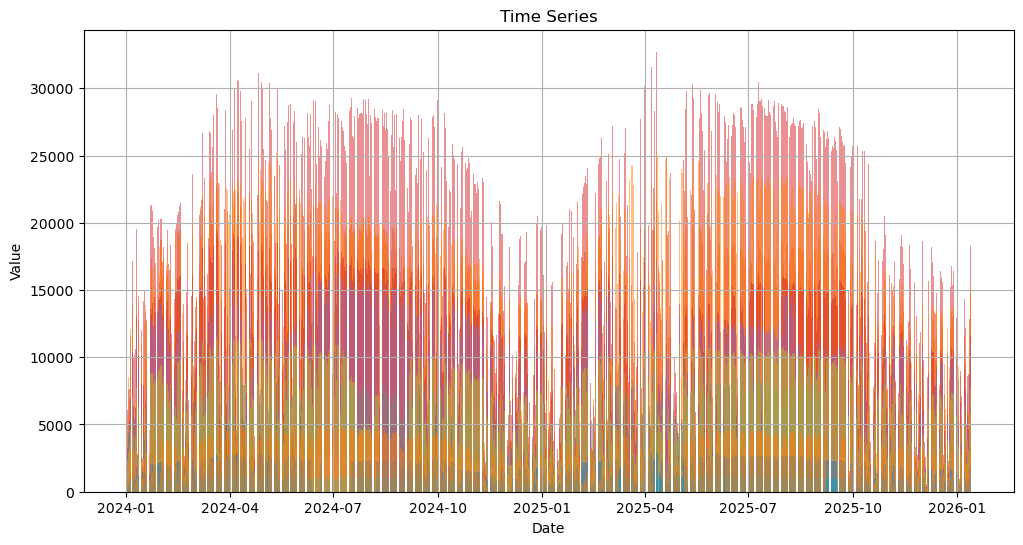

In [33]:
def barplot_timeseries(df: pd.DataFrame, title: str = "Time Series"):
    plt.figure(figsize=(12, 6))
    for col in df.columns:
        plt.bar(df.index, df[col], label=col, alpha=0.5)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    # plt.legend()
    plt.grid()
    plt.show()

barplot_timeseries(daily)

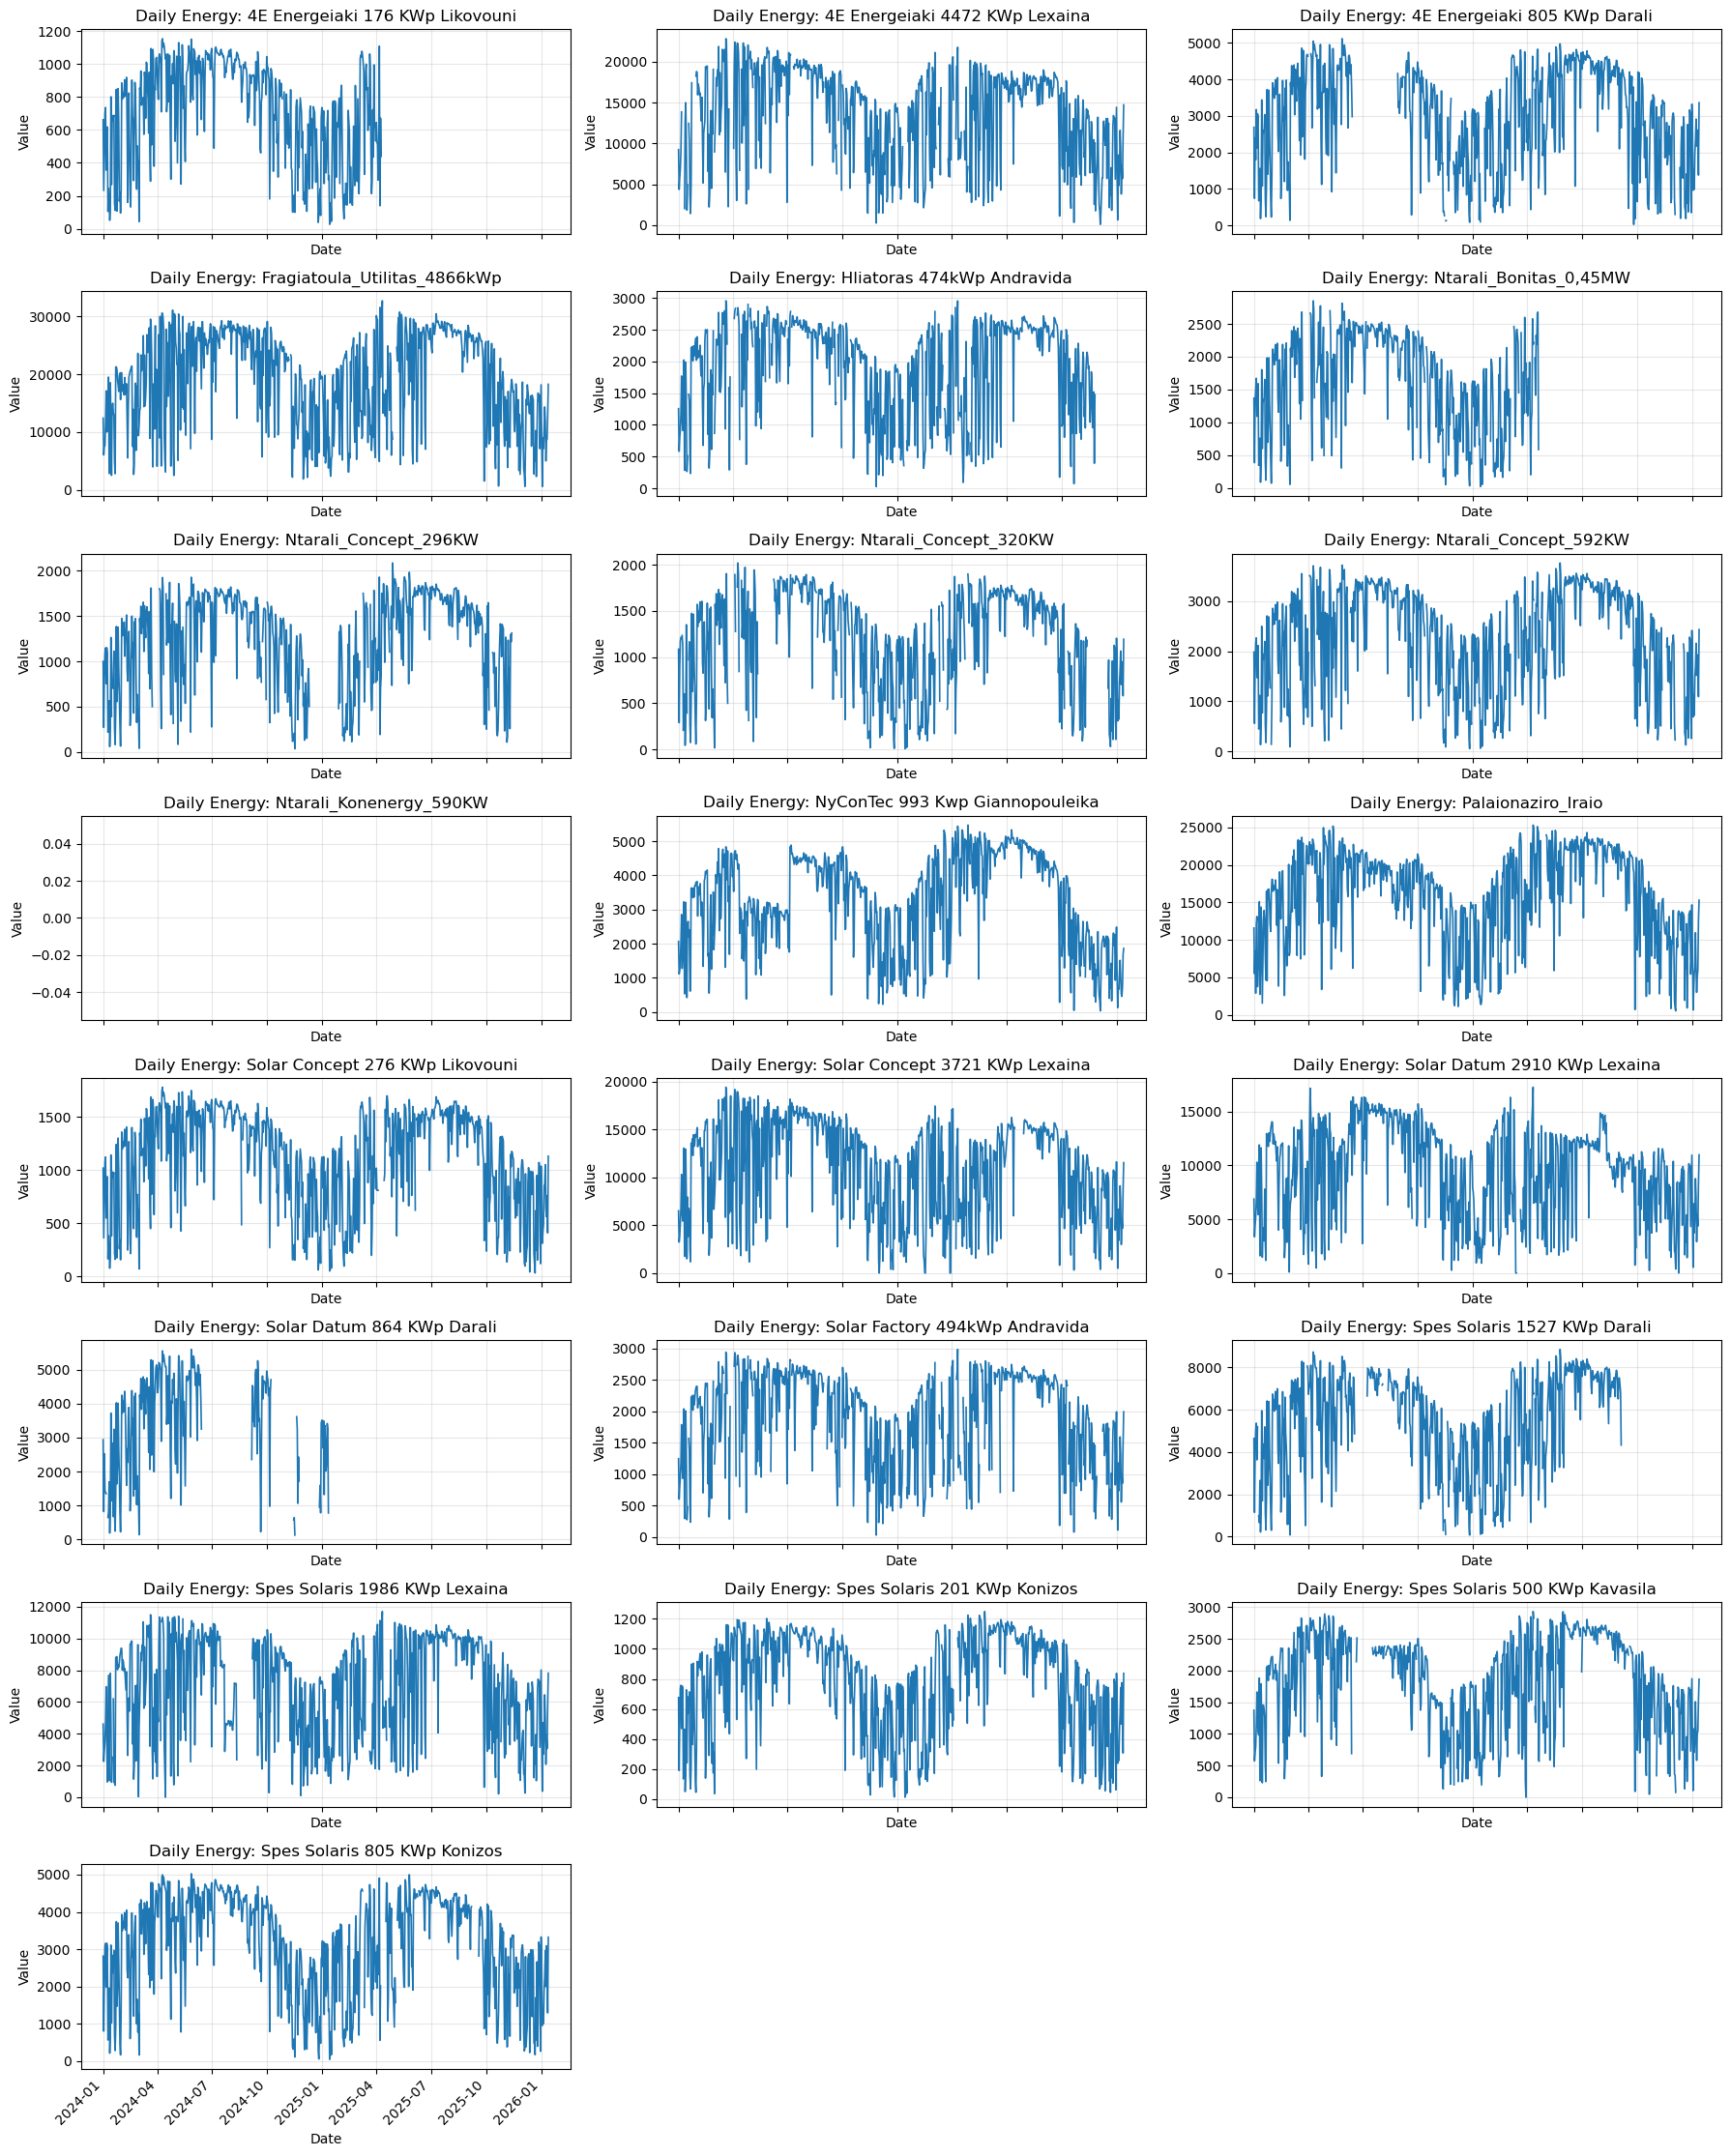

In [34]:
def lineplot_timeseries_per_column(df: pd.DataFrame, title_prefix: str = "Time Series", ncols: int = 3, sharex: bool = True, sharey: bool = False):
    """
    Plot one line chart per column in a grid of subplots.
    
    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame indexed by date; each column is a park/series.
    title_prefix: str
        Prefix used in subplot titles.
    ncols: int
        Number of columns in the subplot grid.
    sharex: bool
        Share x-axis across subplots.
    sharey: bool
        Share y-axis across subplots.
    """
    cols = list(df.columns)
    if len(cols) == 0:
        print("No columns to plot.")
        return

    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    figsize = (min(6 * ncols, 24), max(2.8 * nrows, 4))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey)
    # Ensure axes is 2D array for consistent indexing
    if nrows == 1:
        axes = np.array([axes])
    if ncols == 1:
        axes = axes.reshape(nrows, 1)

    axes_flat = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes_flat[i]
        ax.plot(df.index, df[col], linewidth=1.2)
        # Use short_label if available, else raw column name
        try:
            label = short_label(col)
        except Exception:
            label = col
        ax.set_title(f"{title_prefix}: {label}")
        ax.grid(alpha=0.3)
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")

    # Hide any unused axes
    for j in range(len(cols), len(axes_flat)):
        axes_flat[j].set_visible(False)

    # Rotate x tick labels if many points
    for ax in axes_flat[:len(cols)]:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha('right')

    plt.tight_layout()
    plt.show()

# Example: plot one timeseries per column
lineplot_timeseries_per_column(daily, title_prefix="Daily Energy", ncols=3, sharex=True, sharey=False)


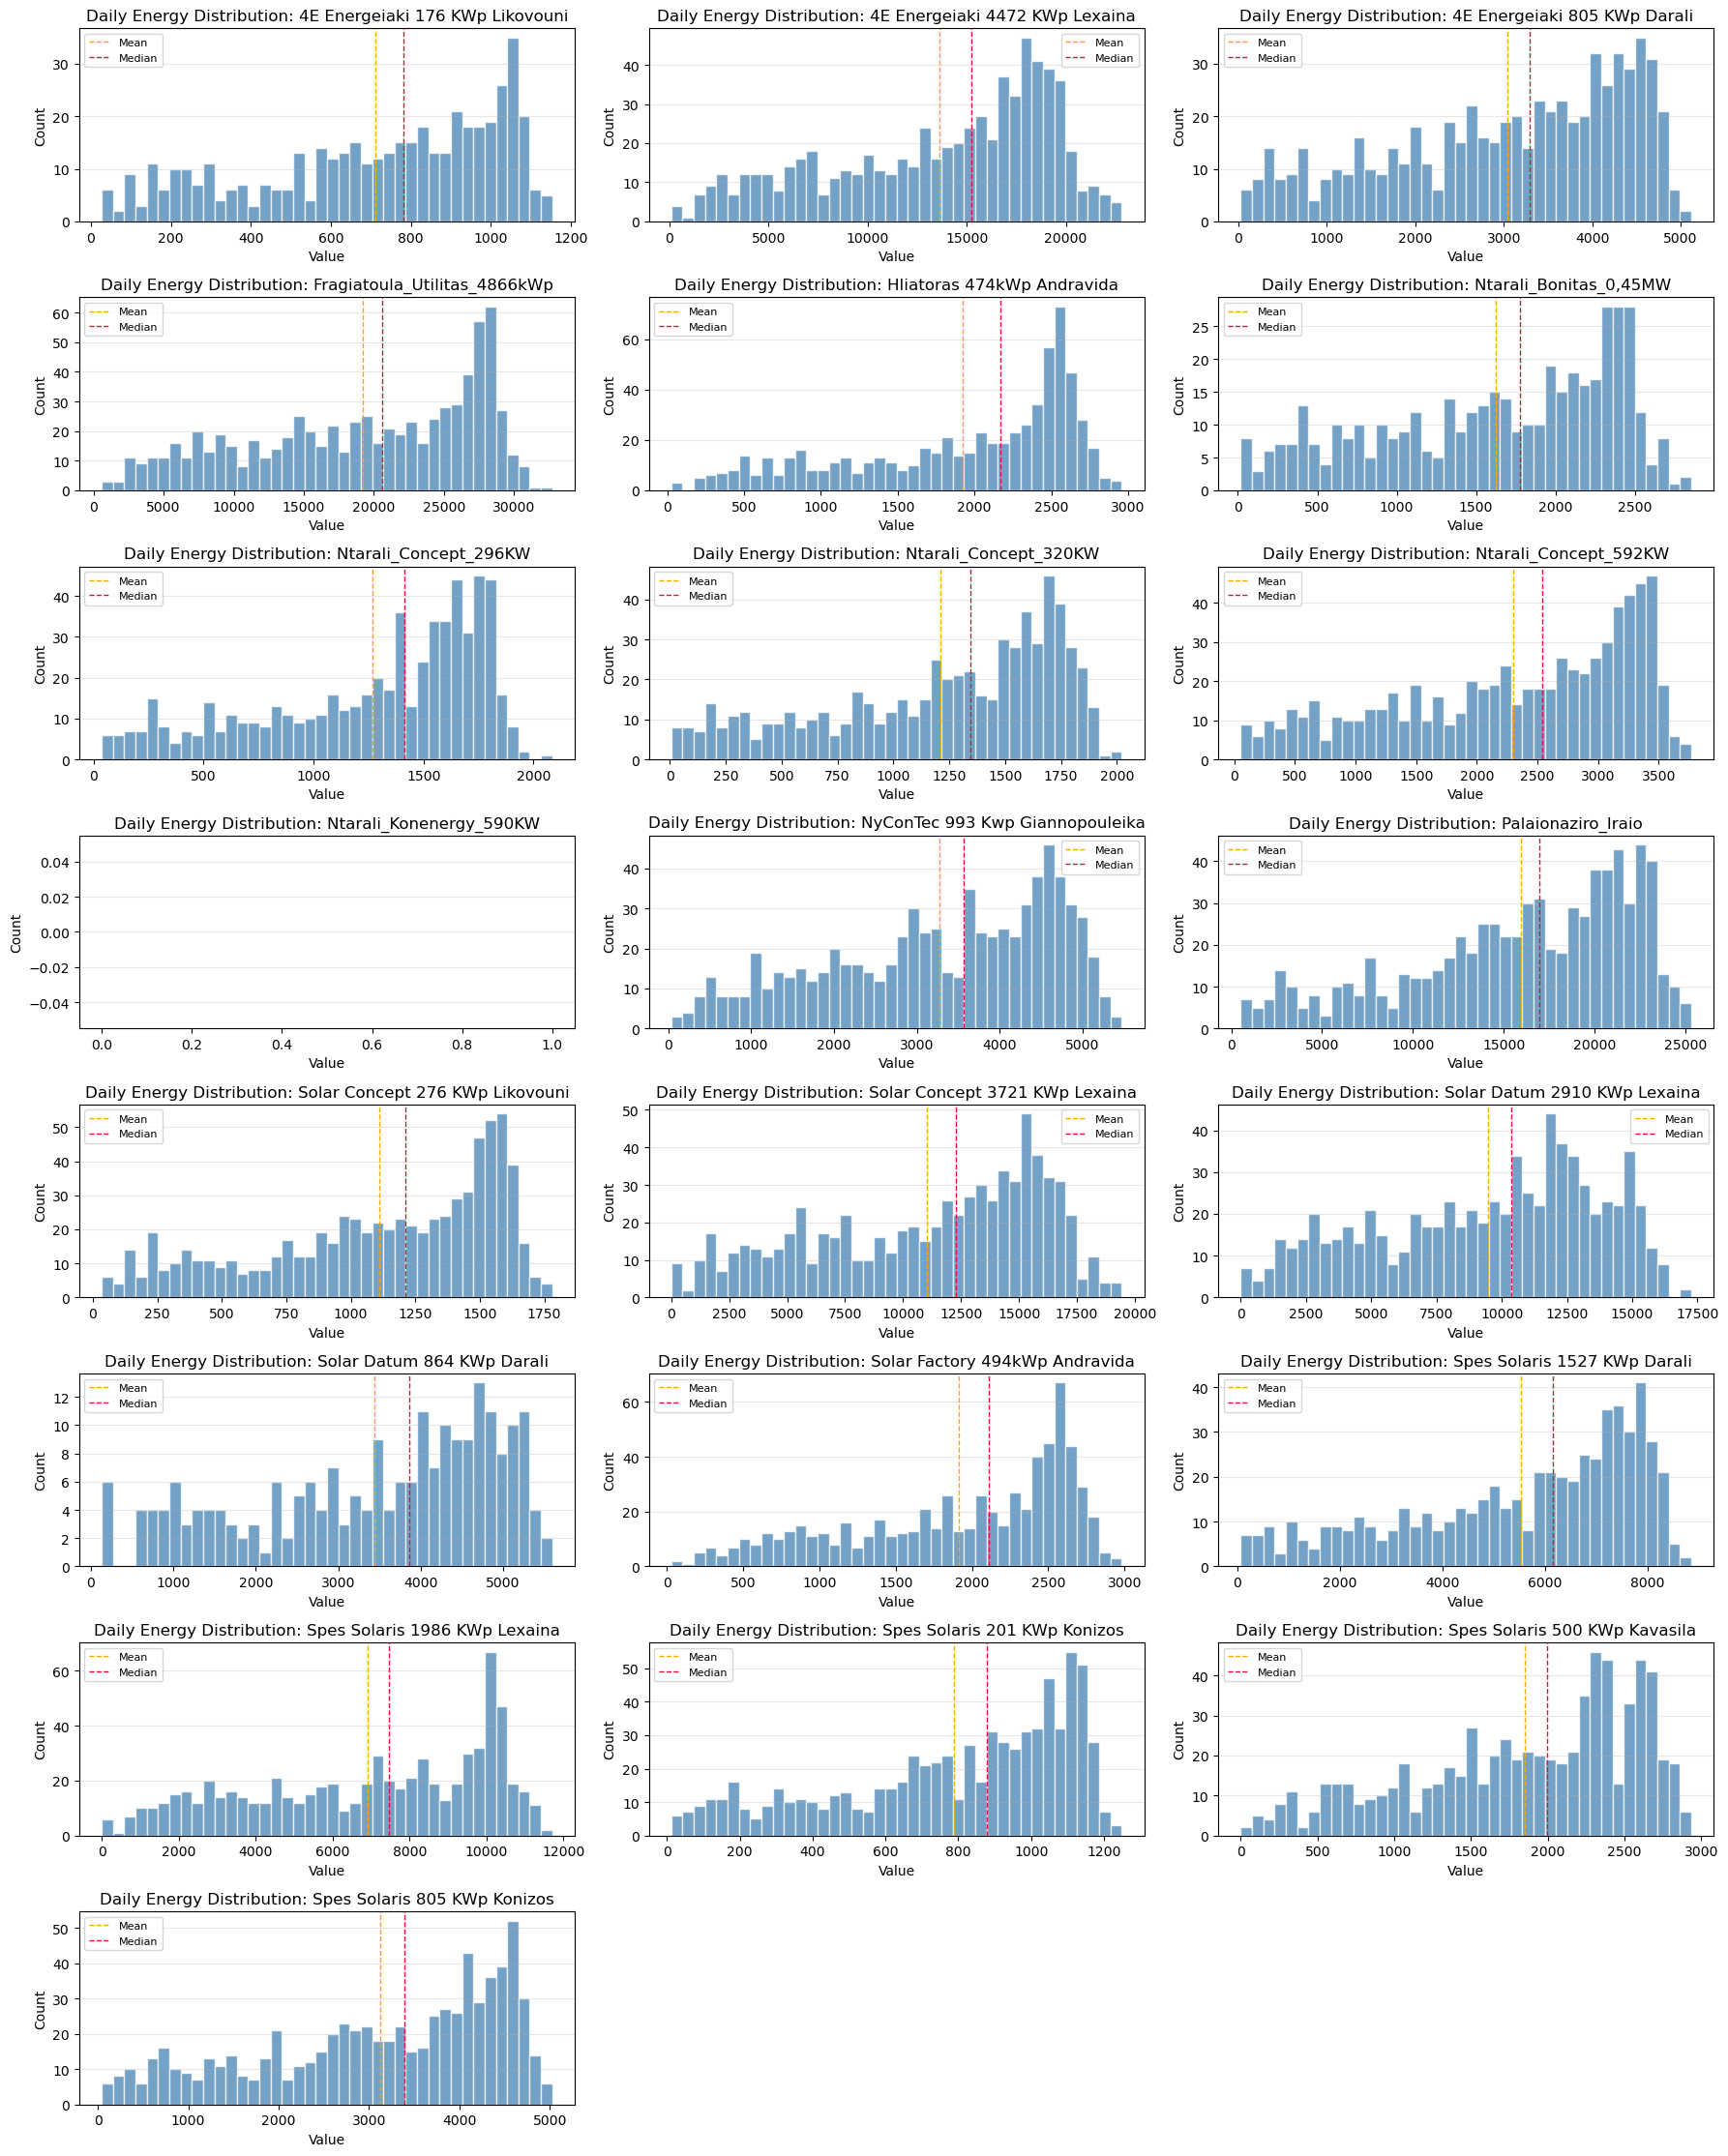

In [35]:
def histplot_distribution_per_column(
    df: pd.DataFrame,
    title_prefix: str = "Distribution",
    ncols: int = 3,
    bins: int = 30,
    density: bool = False,
    dropna: bool = True,
    sharex: bool = False,
    sharey: bool = False,
    show_stats: bool = True,
):
    """
    Plot one histogram per column in a grid of subplots.

    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame indexed by date; each column is a park/series.
    title_prefix: str
        Prefix used in subplot titles.
    ncols: int
        Number of columns in the subplot grid.
    bins: int
        Histogram bin count.
    density: bool
        If True, normalize histogram to form a probability density.
    dropna: bool
        If True, exclude NaNs from each column.
    sharex/sharey: bool
        Share axes across subplots.
    show_stats: bool
        If True, draw vertical lines for mean and median.
    """
    cols = list(df.columns)
    if len(cols) == 0:
        print("No columns to plot.")
        return

    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    figsize = (min(6 * ncols, 24), max(2.8 * nrows, 4))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey)
    if nrows == 1:
        axes = np.array([axes])
    if ncols == 1:
        axes = axes.reshape(nrows, 1)

    axes_flat = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes_flat[i]
        values = df[col]
        if dropna:
            values = values.dropna()

        ax.hist(values, bins=bins, alpha=0.75, color='steelblue', edgecolor='white', density=density)

        # Use short_label if available, else raw column name
        try:
            label = short_label(col)
        except Exception:
            label = col
        ax.set_title(f"{title_prefix}: {label}")
        ax.grid(axis='y', alpha=0.3)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density" if density else "Count")

        if show_stats and len(values) > 0:
            mean_val = float(values.mean())
            median_val = float(values.median())
            ax.axvline(mean_val, color='orange', linestyle='--', linewidth=1, label='Mean')
            ax.axvline(median_val, color='crimson', linestyle='--', linewidth=1, label='Median')
            ax.legend(fontsize=8)

    # Hide any unused axes
    for j in range(len(cols), len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Example: plot one histogram per column
histplot_distribution_per_column(daily, title_prefix="Daily Energy Distribution", ncols=3, bins=40, density=False)


In [36]:
def compute_descriptive_statistics(df: pd.DataFrame):
    stats = df.describe().T
    stats['median'] = df.median()
    stats['std'] = df.std()
    stats['var'] = df.var()
    stats['skew'] = df.skew()
    stats['kurtosis'] = df.kurtosis()
    print(stats)
    return stats
    

compute_descriptive_statistics(daily)

                                                    count          mean  \
[4E Energeiaki 176 KWp Likovouni] PCC PCC activ...  463.0    712.233148   
[4E Energeiaki 4472 KWp Lexaina] PCC PCC active...  677.0  13638.927848   
[4E Energeiaki 805 KWp Darali] PCC PCC active e...  645.0   3035.622776   
[Fragiatoula_Utilitas_4866kWp] PCC PCC active e...  736.0  19192.598399   
[Hliatoras 474kWp Andravida] PCC PCC active ene...  654.0   1922.665898   
[Ntarali_Bonitas_0,45MW] PCC PCC active energy ...  440.0   1622.343800   
[Ntarali_Concept_296KW] PCC PCC active energy e...  604.0   1268.436883   
[Ntarali_Concept_320KW] PCC PCC active energy e...  636.0   1212.625185   
[Ntarali_Concept_592KW] PCC PCC active energy e...  705.0   2300.998244   
[Ntarali_Konenergy_590KW] PCC PCC active energy...    0.0           NaN   
[NyConTec 993 Kwp Giannopouleika] PCC PCC activ...  743.0   3270.669577   
[Palaionaziro_Iraio] PCC PCC active energy expo...  736.0  15926.132563   
[Solar Concept 276 KWp Li

,count,mean,std,min,25%,50%,75%,max,median,var,skew,kurtosis
[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh),463.0,712.233148,304.864273,26.930894,507.774038,782.489107,976.216782,1153.60055,782.489107,9.294222e+04,-0.586052,-0.822885
[4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh),677.0,13638.927848,5574.459099,91.833932,9557.785590,15237.125600,18161.462300,22823.83330,15237.125600,3.107459e+07,-0.609888,-0.760867
[4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh),645.0,3035.622776,1344.590408,26.180930,2021.221900,3292.896110,4201.772960,5119.82167,3292.896110,1.807923e+06,-0.533334,-0.835149
[Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh),736.0,19192.598399,8137.525736,583.974040,13057.722300,20569.384400,26828.225650,32724.21230,20569.384400,6.621933e+07,-0.472972,-0.996903
[Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh),654.0,1922.665898,734.056838,27.026498,1402.235127,2166.439060,2530.229447,2958.11396,2166.439060,5.388394e+05,-0.792427,-0.599240
"[Ntarali_Bonitas_0,45MW] PCC PCC active energy export (kWh)",440.0,1622.343800,741.106617,18.407118,1048.942663,1774.024405,2293.140920,2854.41966,1774.024405,5.492390e+05,-0.492077,-0.941313
[Ntarali_Concept_296KW] PCC PCC active energy export (kWh),604.0,1268.436883,502.616272,37.376786,924.687143,1412.624580,1671.592970,2085.10587,1412.624580,2.526231e+05,-0.802824,-0.493158
[Ntarali_Concept_320KW] PCC PCC active energy export (kWh),636.0,1212.625185,524.352052,6.507222,835.000900,1343.285555,1653.297500,2021.63193,1343.285555,2.749451e+05,-0.688472,-0.684125
[Ntarali_Concept_592KW] PCC PCC active energy export (kWh),705.0,2300.998244,993.545336,52.779438,1525.943960,2536.244820,3186.639220,3768.81423,2536.244820,9.871323e+05,-0.581051,-0.847283
[Ntarali_Konenergy_590KW] PCC PCC active energy export (kWh),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


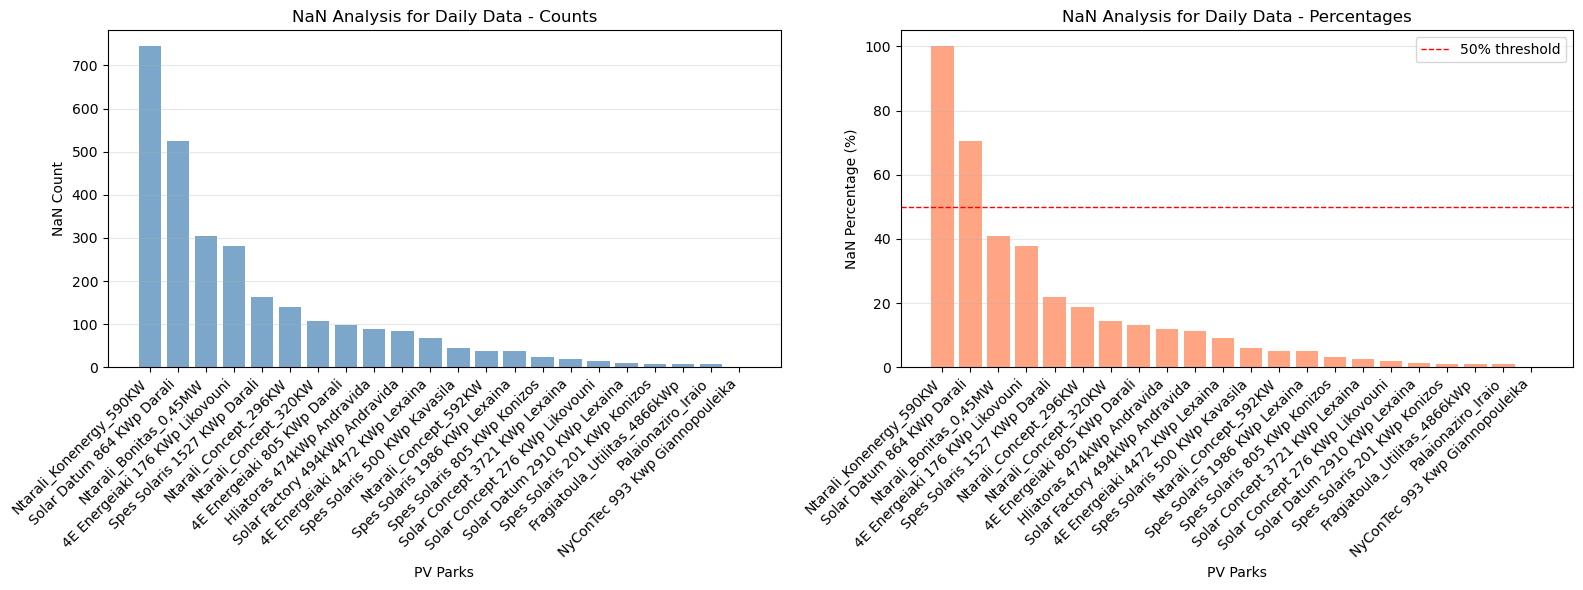


Total columns: 22
Columns with NaN: 22
Columns with >50% NaN: 2


In [37]:
def barplot_nan_count(df: pd.DataFrame, title: str = "NaN Count per Column"):
    """
    Create a bar plot showing the count and percentage of NaN values for each column.
    
    Parameters:
    -----------
    df: pd.DataFrame
        The dataframe to analyze
    title: str
        Plot title
    """
    nan_counts = df.isna().sum()
    nan_pcts = (df.isna().sum() / len(df)) * 100
    
    # Sort by count descending
    nan_counts = nan_counts.sort_values(ascending=False)
    nan_pcts = nan_pcts[nan_counts.index]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of counts
    ax1.bar(range(len(nan_counts)), nan_counts.values, color='steelblue', alpha=0.7)
    ax1.set_xticks(range(len(nan_counts)))
    ax1.set_xticklabels([short_label(col) for col in nan_counts.index], rotation=45, ha='right')
    ax1.set_ylabel("NaN Count")
    ax1.set_xlabel("PV Parks")
    ax1.set_title(f"{title} - Counts")
    ax1.grid(axis='y', alpha=0.3)
    
    # Bar plot of percentages
    ax2.bar(range(len(nan_pcts)), nan_pcts.values, color='coral', alpha=0.7)
    ax2.set_xticks(range(len(nan_pcts)))
    ax2.set_xticklabels([short_label(col) for col in nan_pcts.index], rotation=45, ha='right')
    ax2.set_ylabel("NaN Percentage (%)")
    ax2.set_xlabel("PV Parks")
    ax2.set_title(f"{title} - Percentages")
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=50, color='red', linestyle='--', linewidth=1, label='50% threshold')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return nan_counts, nan_pcts

nan_counts, nan_pcts = barplot_nan_count(daily, "NaN Analysis for Daily Data")
print(f"\nTotal columns: {len(daily.columns)}")
print(f"Columns with NaN: {(nan_counts > 0).sum()}")
print(f"Columns with >50% NaN: {(nan_pcts > 50).sum()}")


In [38]:
def detect_problematic_columns(df: pd.DataFrame, nan_threshold: float = 0.5, zero_threshold: float = 0.8) -> dict:
    """
    Detect columns that are mostly NaN, missing, or zeros.
    
    Parameters:
    -----------
    df: pd.DataFrame
        The dataframe to analyze
    nan_threshold: float
        Fraction of NaN/missing values above which a column is flagged (default: 0.5 = 50%)
    zero_threshold: float
        Fraction of zero values (among non-NaN) above which a column is flagged (default: 0.8 = 80%)
    
    Returns:
    --------
    dict with keys:
        - 'mostly_nan': list of columns with high NaN percentage
        - 'mostly_zero': list of columns with high zero percentage
        - 'summary': DataFrame with statistics for each column
    """
    results = {
        'mostly_nan': [],
        'mostly_zero': [],
        'summary': []
    }
    
    for col in df.columns:
        total_count = len(df[col])
        nan_count = df[col].isna().sum()
        nan_pct = nan_count / total_count if total_count > 0 else 0
        
        # For zero detection, only consider non-NaN values
        non_nan_values = df[col].dropna()
        non_nan_count = len(non_nan_values)
        
        if non_nan_count > 0:
            zero_count = (non_nan_values == 0).sum()
            zero_pct = zero_count / non_nan_count
        else:
            zero_count = 0
            zero_pct = 0
        
        # Store summary
        results['summary'].append({
            'column': col,
            'total_rows': total_count,
            'nan_count': nan_count,
            'nan_pct': nan_pct,
            'non_nan_count': non_nan_count,
            'zero_count': zero_count,
            'zero_pct': zero_pct,
        })
        
        # Flag problematic columns
        if nan_pct >= nan_threshold:
            results['mostly_nan'].append(col)
        
        if zero_pct >= zero_threshold:
            results['mostly_zero'].append(col)
    
    results['summary'] = pd.DataFrame(results['summary'])
    
    return results

# Example usage
problematic = detect_problematic_columns(daily, nan_threshold=0.5, zero_threshold=0.8)

print("=== Columns with mostly NaN (≥50%) ===")
if problematic['mostly_nan']:
    for col in problematic['mostly_nan']:
        stats = problematic['summary'][problematic['summary']['column'] == col].iloc[0]
        print(f"  {col}: {stats['nan_pct']*100:.1f}% NaN ({stats['nan_count']}/{stats['total_rows']})")
else:
    print("  None found")

print("\n=== Columns with mostly zeros (≥80% of non-NaN) ===")
if problematic['mostly_zero']:
    for col in problematic['mostly_zero']:
        stats = problematic['summary'][problematic['summary']['column'] == col].iloc[0]
        print(f"  {col}: {stats['zero_pct']*100:.1f}% zeros ({stats['zero_count']}/{stats['non_nan_count']} non-NaN)")
else:
    print("  None found")

print("\n=== Summary Statistics ===")
print(problematic['summary'][['column', 'nan_pct', 'zero_pct']].to_string(index=False))


=== Columns with mostly NaN (≥50%) ===
  [Ntarali_Konenergy_590KW] PCC PCC active energy export (kWh): 100.0% NaN (744/744)
  [Solar Datum 864 KWp Darali] PCC PCC active energy export (kWh): 70.4% NaN (524/744)

=== Columns with mostly zeros (≥80% of non-NaN) ===
  None found

=== Summary Statistics ===
                                                              column  nan_pct  zero_pct
[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh) 0.377688  0.000000
 [4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh) 0.090054  0.000000
   [4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh) 0.133065  0.000000
   [Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh) 0.010753  0.000000
     [Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh) 0.120968  0.000000
         [Ntarali_Bonitas_0,45MW] PCC PCC active energy export (kWh) 0.408602  0.000000
          [Ntarali_Concept_296KW] PCC PCC active energy export (kWh) 0.188172  

C:\Users\nbesiridis\AppData\Local\Temp\ipykernel_8660\362290088.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, patch_artist=True, showmeans=True,


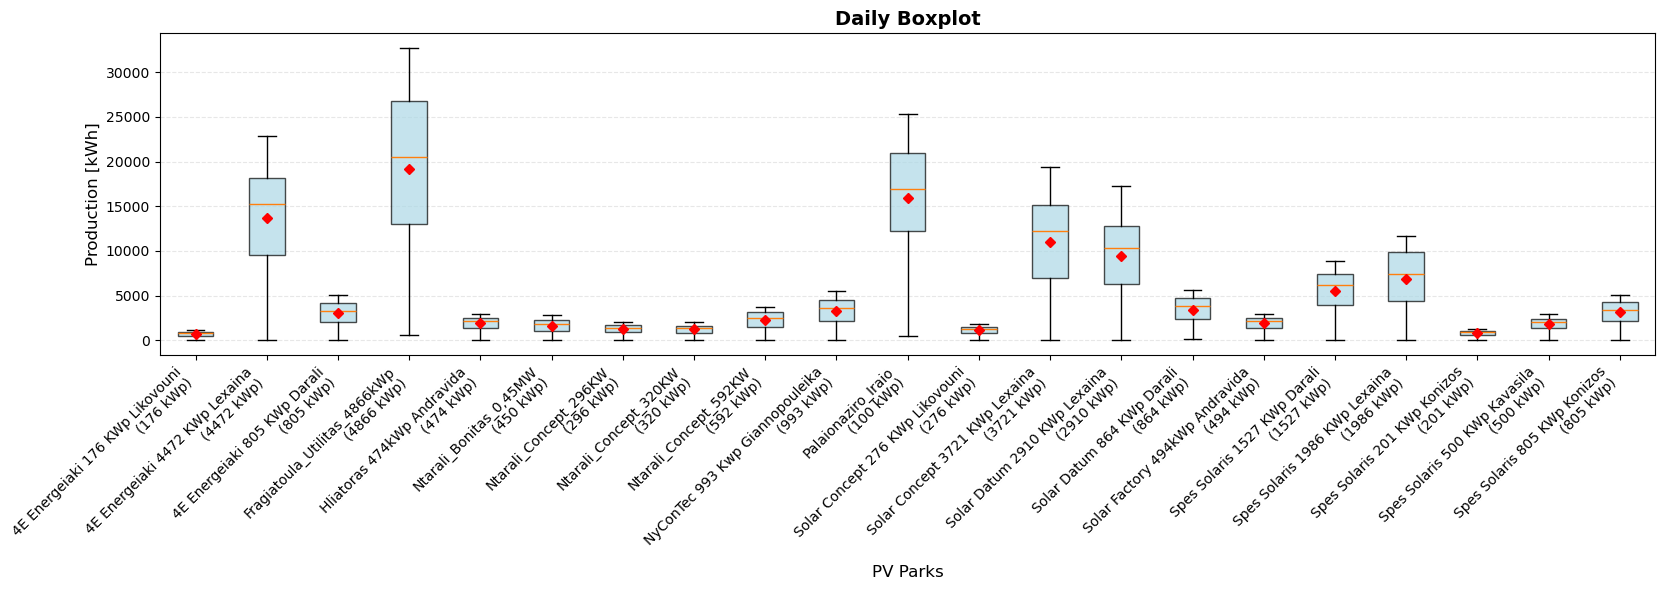

In [39]:
def plot_boxplot(mat: pd.DataFrame, title: str, ylabel: str = "Production [kWh]", ylim=None):
    """
    Create boxplots for each park showing the distribution of values across all dates.
    
    Parameters:
    -----------
    mat: pd.DataFrame
        Date x park dataframe with values to plot
    title: str
        Plot title
    ylabel: str
        Y-axis label (default: "KPI")
    ylim: tuple or None
        Y-axis limits as (min, max)
    """
    # Prepare data - we want boxplots for each park (column)
    data_list = []
    labels = []
    
    for col in mat.columns:
        # Get non-NaN values for this park
        values = mat[col].dropna()
        if len(values) > 0:
            data_list.append(values)
            labels.append(f"{short_label(col)}\n({parse_kwp_from_header(col):.0f} kWp)")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(max(12, 0.8 * len(labels)), 6))
    
    bp = ax.boxplot(data_list, labels=labels, patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='red', markersize=5))
    
    # Customize box colors
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("PV Parks", fontsize=12)
    
    # Rotate x labels if many parks
    if len(labels) > 10:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

plot_boxplot(daily, title="Daily Boxplot")


In [40]:
def detect_outliers_iqr(df: pd.DataFrame, multiplier: float = 1.5) -> dict:
    """
    Detect outliers using the Interquartile Range (IQR) method.
    
    Parameters:
    -----------
    df: pd.DataFrame
        The dataframe to analyze
    multiplier: float
        IQR multiplier for outlier detection (default: 1.5)
        - 1.5 is standard for outliers
        - 3.0 is often used for extreme outliers
    
    Returns:
    --------
    dict with keys:
        - 'outlier_counts': Series with count of outliers per column
        - 'outlier_pcts': Series with percentage of outliers per column
        - 'outlier_mask': DataFrame with True for outliers, False otherwise
        - 'bounds': DataFrame with lower_bound and upper_bound per column
        - 'summary': DataFrame with statistics for each column
    """
    results = {
        'outlier_counts': {},
        'outlier_pcts': {},
        'outlier_mask': pd.DataFrame(index=df.index),
        'bounds': [],
        'summary': []
    }
    
    for col in df.columns:
        # Skip columns with insufficient non-NaN values
        non_nan_values = df[col].dropna()
        if len(non_nan_values) < 4:
            results['outlier_counts'][col] = 0
            results['outlier_pcts'][col] = 0.0
            results['outlier_mask'][col] = False
            results['bounds'].append({
                'column': col,
                'lower_bound': np.nan,
                'upper_bound': np.nan,
                'Q1': np.nan,
                'Q3': np.nan,
                'IQR': np.nan
            })
            continue
        
        # Calculate quartiles and IQR
        Q1 = non_nan_values.quantile(0.25)
        Q3 = non_nan_values.quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate bounds
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Detect outliers
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_count = outlier_mask.sum()
        outlier_pct = (outlier_count / len(non_nan_values)) * 100 if len(non_nan_values) > 0 else 0
        
        results['outlier_counts'][col] = outlier_count
        results['outlier_pcts'][col] = outlier_pct
        results['outlier_mask'][col] = outlier_mask
        
        results['bounds'].append({
            'column': col,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR
        })
        
        results['summary'].append({
            'column': col,
            'total_values': len(df[col]),
            'non_nan_values': len(non_nan_values),
            'outlier_count': outlier_count,
            'outlier_pct': outlier_pct,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
        })
    
    results['outlier_counts'] = pd.Series(results['outlier_counts'])
    results['outlier_pcts'] = pd.Series(results['outlier_pcts'])
    results['bounds'] = pd.DataFrame(results['bounds'])
    results['summary'] = pd.DataFrame(results['summary'])
    
    return results

# Detect outliers in the daily dataframe
outliers = detect_outliers_iqr(daily, multiplier=1.5)

print("=== Outlier Detection Summary (IQR method) ===")
print(f"Total columns analyzed: {len(daily.columns)}")
print(f"Columns with outliers: {(outliers['outlier_counts'] > 0).sum()}")
print(f"\nTop 10 columns with most outliers:")
top_outliers = outliers['summary'].sort_values('outlier_count', ascending=False).head(10)
print(top_outliers[['column', 'outlier_count', 'outlier_pct', 'lower_bound', 'upper_bound']].to_string(index=False))

=== Outlier Detection Summary (IQR method) ===
Total columns analyzed: 22
Columns with outliers: 0

Top 10 columns with most outliers:
                                                              column  outlier_count  outlier_pct  lower_bound  upper_bound
[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh)              0          0.0  -194.890077  1678.880897
 [4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh)              0          0.0 -3347.729475 31066.977365
   [4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh)              0          0.0 -1249.604690  7472.599550
   [Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh)              0          0.0 -7598.032725 47483.980675
     [Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh)              0          0.0  -289.756353  4222.220928
         [Ntarali_Bonitas_0,45MW] PCC PCC active energy export (kWh)              0          0.0  -817.354724  4159.438306
    

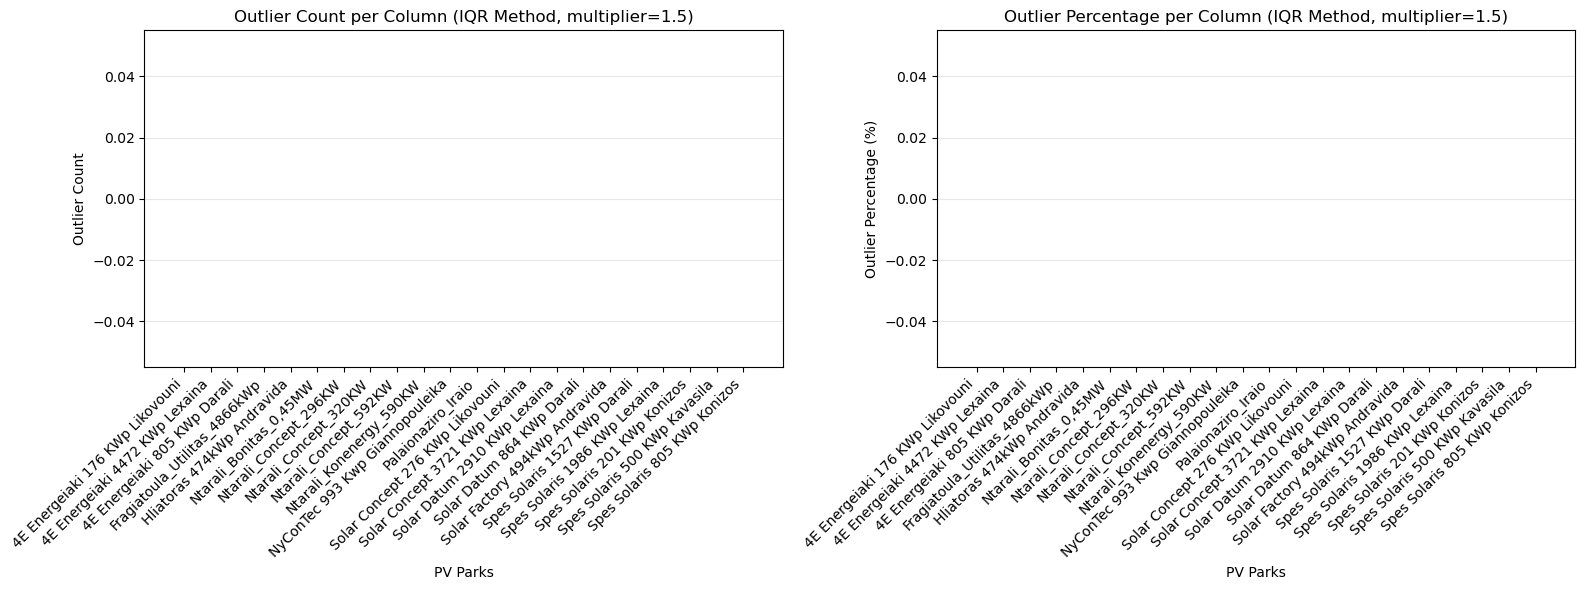

In [41]:
def visualize_outliers(outliers_result: dict, title_suffix: str = "IQR Method"):
    """
    Visualize outlier detection results with bar plots.
    
    Parameters:
    -----------
    outliers_result: dict
        Result dictionary from detect_outliers_iqr function
    title_suffix: str
        Suffix to add to plot titles (default: "IQR Method")
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of outlier counts
    sorted_counts = outliers_result['outlier_counts'].sort_values(ascending=False)
    ax1.bar(range(len(sorted_counts)), sorted_counts.values, color='crimson', alpha=0.7)
    ax1.set_xticks(range(len(sorted_counts)))
    ax1.set_xticklabels([short_label(col) for col in sorted_counts.index], rotation=45, ha='right')
    ax1.set_ylabel("Outlier Count")
    ax1.set_xlabel("PV Parks")
    ax1.set_title(f"Outlier Count per Column ({title_suffix})")
    ax1.grid(axis='y', alpha=0.3)
    
    # Bar plot of outlier percentages
    sorted_pcts = outliers_result['outlier_pcts'].sort_values(ascending=False)
    ax2.bar(range(len(sorted_pcts)), sorted_pcts.values, color='orange', alpha=0.7)
    ax2.set_xticks(range(len(sorted_pcts)))
    ax2.set_xticklabels([short_label(col) for col in sorted_pcts.index], rotation=45, ha='right')
    ax2.set_ylabel("Outlier Percentage (%)")
    ax2.set_xlabel("PV Parks")
    ax2.set_title(f"Outlier Percentage per Column ({title_suffix})")
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize the outliers
visualize_outliers(outliers, title_suffix="IQR Method, multiplier=1.5")


In [42]:
# ASSUMPTIONS:
# - random lat/lon inside Greece bounding box
# - loss_pct = 18% for older parks
# - timezone = Europe/Athens
meta = make_random_greece_meta(
    park_columns=park_cols,
    seed=7,
    loss_pct=18.0,
    timezone="Europe/Athens"
)

meta.head()


,park_label,kwp,latitude,longitude,loss_pct,timezone,tilt_deg,azimuth_deg
column_header,,,,,,,,
[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh),4E Energeiaki 176 KWp Likovouni,176.0,39.175668,24.696618,18.0,Europe/Athens,NaN,NaN
[4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh),4E Energeiaki 4472 KWp Lexaina,4472.0,41.080497,19.408661,18.0,Europe/Athens,NaN,NaN
[4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh),4E Energeiaki 805 KWp Darali,805.0,40.229800,19.331827,18.0,Europe/Athens,NaN,NaN
[Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh),Fragiatoula_Utilitas_4866kWp,4866.0,36.376450,23.788466,18.0,Europe/Athens,NaN,NaN
[Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh),Hliatoras 474kWp Andravida,474.0,36.901164,23.335716,18.0,Europe/Athens,NaN,NaN


In [43]:
# Debug: Check date range that will be used
print(f"Date range in data: {daily.index.min()} to {daily.index.max()}")
print(f"Data years: {daily.index.min().year} to {daily.index.max().year}")

Date range in data: 2024-01-01 00:00:00 to 2026-01-13 00:00:00
Data years: 2024 to 2026


In [44]:
# Reload the module to pick up the fix
importlib.reload(pvgis_pi_heatmap)
from src.pvgis_pi_heatmap import compute_pi_anomaly

# Recompute with the fixed function
pi_fixed, score_fixed, flag_fixed = compute_pi_anomaly(
    daily_df=daily,
    meta=meta,
    cache_dir=CACHE_DIR,
    pvgis_url="https://re.jrc.ec.europa.eu/api/",
)

print("\nFixed PI data info:")
print(f"  Total rows: {len(pi_fixed)}")
print(f"  Non-NaN rows: {pi_fixed.notna().any(axis=1).sum()}")
print(f"  First non-NaN date: {pi_fixed[pi_fixed.notna().any(axis=1)].index.min() if pi_fixed.notna().any(axis=1).any() else 'None'}")
print(f"  Last non-NaN date: {pi_fixed[pi_fixed.notna().any(axis=1)].index.max() if pi_fixed.notna().any(axis=1).any() else 'None'}")
print(f"\nData after 2024-12-31:")
pi_2025plus = pi_fixed[pi_fixed.index > '2024-12-31']
print(f"  Rows: {len(pi_2025plus)}")
print(f"  Non-NaN values: {pi_2025plus.notna().sum().sum()}")

# Update the main variables
pi = pi_fixed
score = score_fixed
flag = flag_fixed

PVGIS per park:   5%|▍         | 1/22 [00:00<00:07,  2.63it/s]

PVGIS per park:  36%|███▋      | 8/22 [00:02<00:03,  4.35it/s]

PVGIS per park:  50%|█████     | 11/22 [00:03<00:01,  5.57it/s]

PVGIS per park:  91%|█████████ | 20/22 [00:04<00:00,  8.95it/s]

PVGIS per park: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s]


Fixed PI data info:
  Total rows: 744
  Non-NaN rows: 742
  First non-NaN date: 2024-01-02 00:00:00
  Last non-NaN date: 2026-01-13 00:00:00

Data after 2024-12-31:
  Rows: 378
  Non-NaN values: 4830


In [45]:
print("Daily data date range:")
print(f"  Start: {daily.index.min()}")
print(f"  End: {daily.index.max()}")
print(f"  Years: {daily.index.min().year} to {daily.index.max().year}")
print(f"\nPI data info:")
print(f"  Total rows: {len(pi)}")
print(f"  Non-NaN rows: {pi.notna().any(axis=1).sum()}")
print(f"  First non-NaN date: {pi[pi.notna().any(axis=1)].index.min() if pi.notna().any(axis=1).any() else 'None'}")
print(f"  Last non-NaN date: {pi[pi.notna().any(axis=1)].index.max() if pi.notna().any(axis=1).any() else 'None'}")
print(f"\nData after 2024-01-01:")
pi_2024plus = pi[pi.index >= '2024-01-01']
print(f"  Rows: {len(pi_2024plus)}")
print(f"  Non-NaN values: {pi_2024plus.notna().sum().sum()}")

Daily data date range:
  Start: 2024-01-01 00:00:00
  End: 2026-01-13 00:00:00
  Years: 2024 to 2026

PI data info:
  Total rows: 744
  Non-NaN rows: 742
  First non-NaN date: 2024-01-02 00:00:00
  Last non-NaN date: 2026-01-13 00:00:00

Data after 2024-01-01:
  Rows: 744
  Non-NaN values: 9921


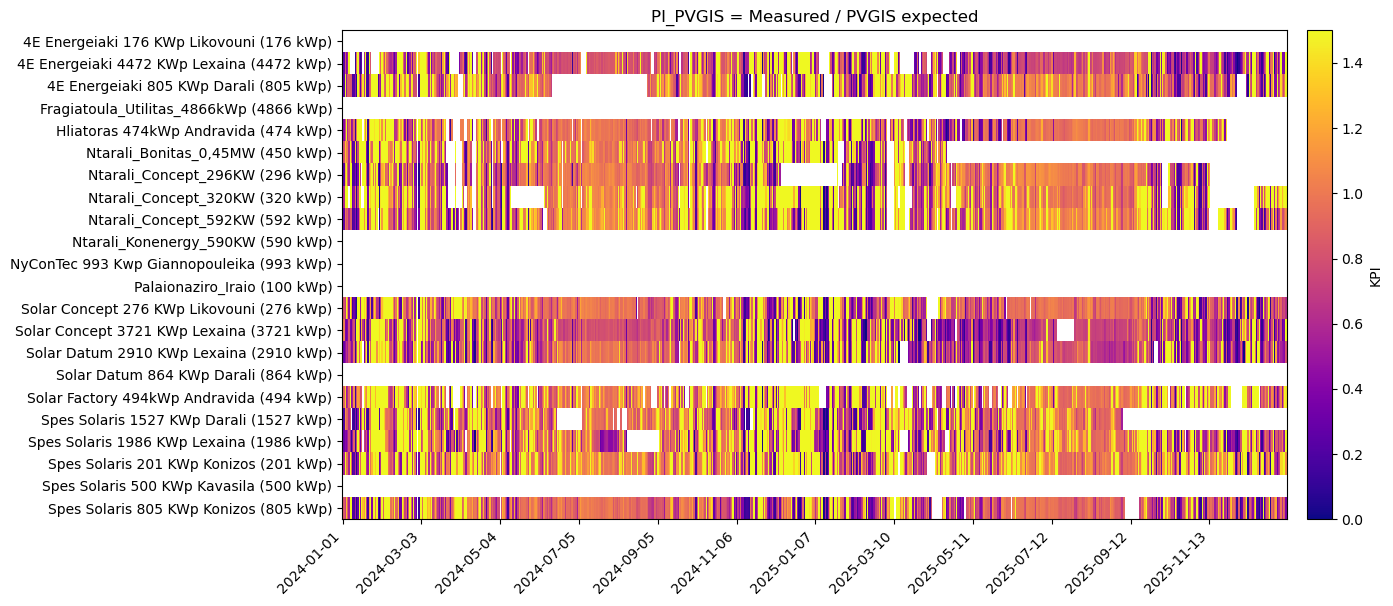

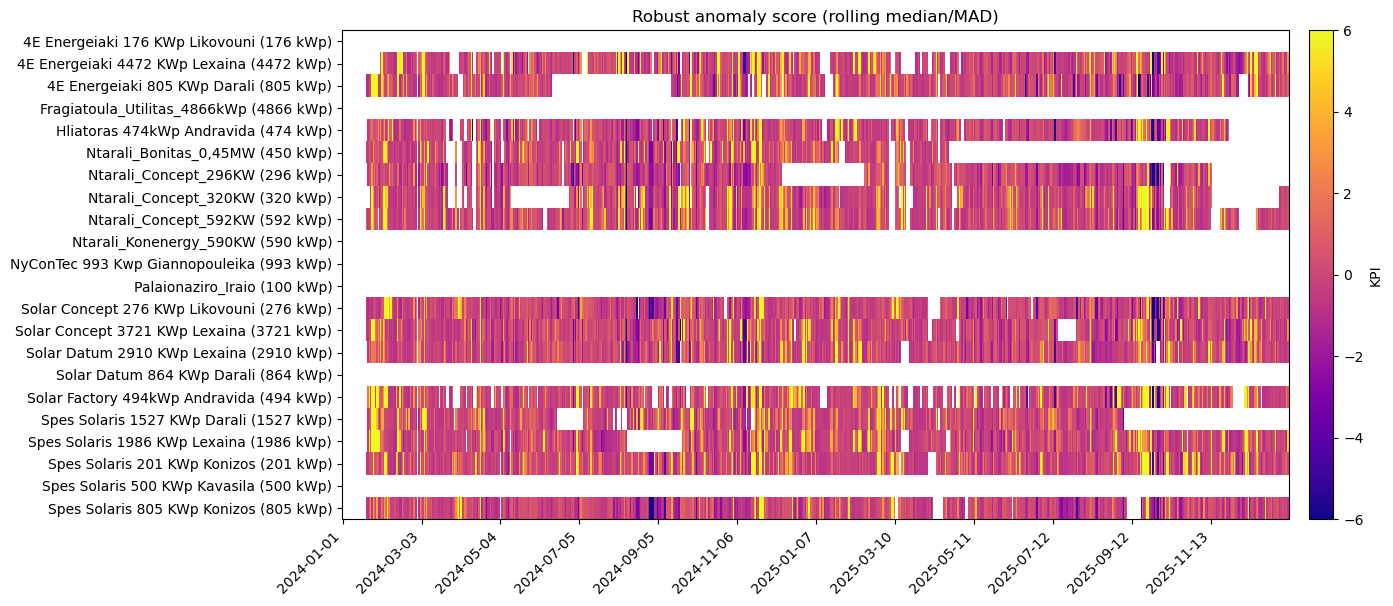

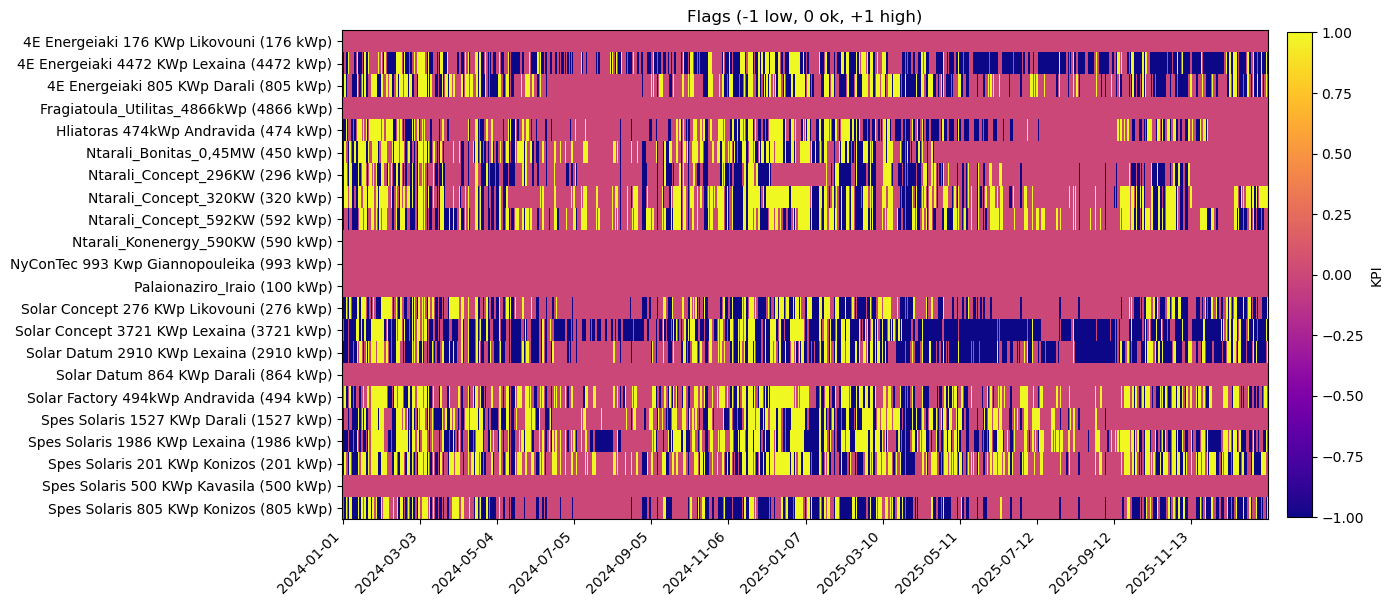

In [46]:
def plot_heatmap(mat: pd.DataFrame, title: str, vmin=None, vmax=None, start_date=None, end_date=None):
    """
    Plot a heatmap of date x park data.
    
    Parameters:
    -----------
    mat: pd.DataFrame
        Date x park dataframe with values to plot
    title: str
        Plot title
    vmin: float or None
        Minimum value for colormap
    vmax: float or None
        Maximum value for colormap
    start_date: str or pd.Timestamp or None
        Start date for filtering (inclusive). Format: 'YYYY-MM-DD' or any pandas-compatible date
    end_date: str or pd.Timestamp or None
        End date for filtering (inclusive). Format: 'YYYY-MM-DD' or any pandas-compatible date
    """
    # Filter by date range if specified
    if start_date is not None or end_date is not None:
        if start_date is not None:
            start_date = pd.to_datetime(start_date)
            mat = mat[mat.index >= start_date]
        if end_date is not None:
            end_date = pd.to_datetime(end_date)
            mat = mat[mat.index <= end_date]
        
        if len(mat) == 0:
            print(f"Warning: No data found in the specified date range")
            return
    
    # mat: date x park -> we plot parks x dates
    m = mat.T.copy()

    # nicer y labels (park label + kWp)
    y = []
    for col in m.index:
        y.append(f"{short_label(col)} ({parse_kwp_from_header(col):.0f} kWp)")
    m.index = y

    fig, ax = plt.subplots(figsize=(14, max(6, 0.28 * len(m.index))))
    im = ax.imshow(m.values, aspect="auto", interpolation="nearest", cmap="plasma", vmin=vmin, vmax=vmax)

    ax.set_title(title)
    ax.set_yticks(np.arange(len(m.index)))
    ax.set_yticklabels(m.index)

    dates = pd.to_datetime(m.columns)
    step = max(1, len(dates) // 12)
    xticks = np.arange(0, len(dates), step)
    ax.set_xticks(xticks)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in dates[::step]], rotation=45, ha="right")

    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
    cbar.ax.set_ylabel("KPI", rotation=90)
    plt.tight_layout()
    plt.show()

# Examples showing all data
plot_heatmap(pi, "PI_PVGIS = Measured / PVGIS expected", vmin=0.0, vmax=1.5)
plot_heatmap(score, "Robust anomaly score (rolling median/MAD)", vmin=-6, vmax=6)
plot_heatmap(flag, "Flags (-1 low, 0 ok, +1 high)", vmin=-1, vmax=1)


C:\Users\nbesiridis\AppData\Local\Temp\ipykernel_8660\362290088.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, patch_artist=True, showmeans=True,


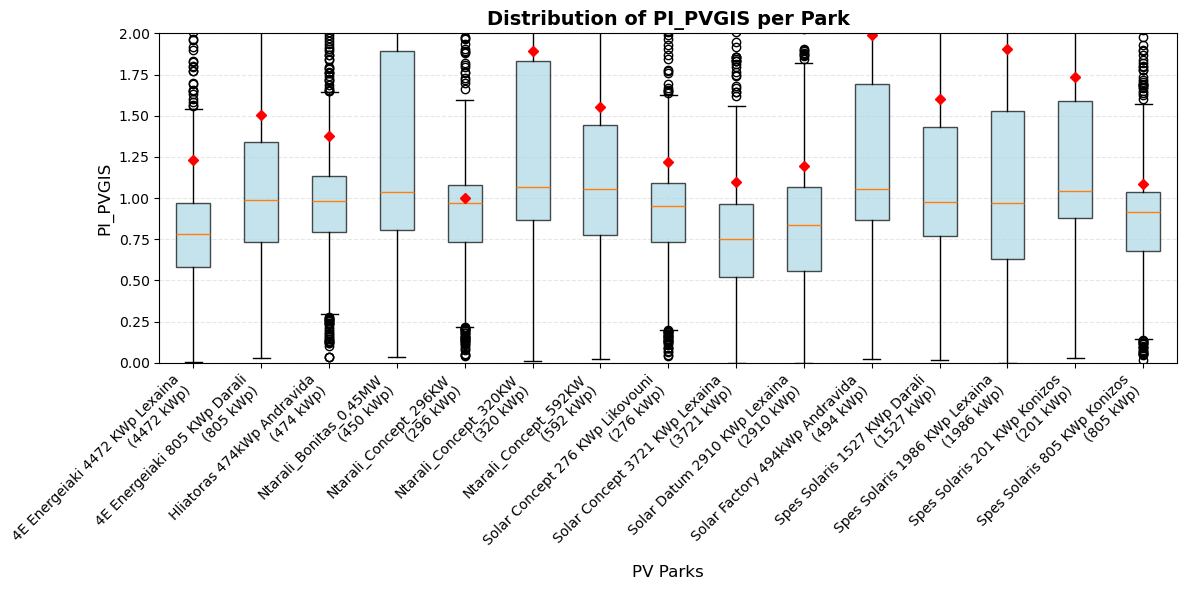

C:\Users\nbesiridis\AppData\Local\Temp\ipykernel_8660\362290088.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, patch_artist=True, showmeans=True,


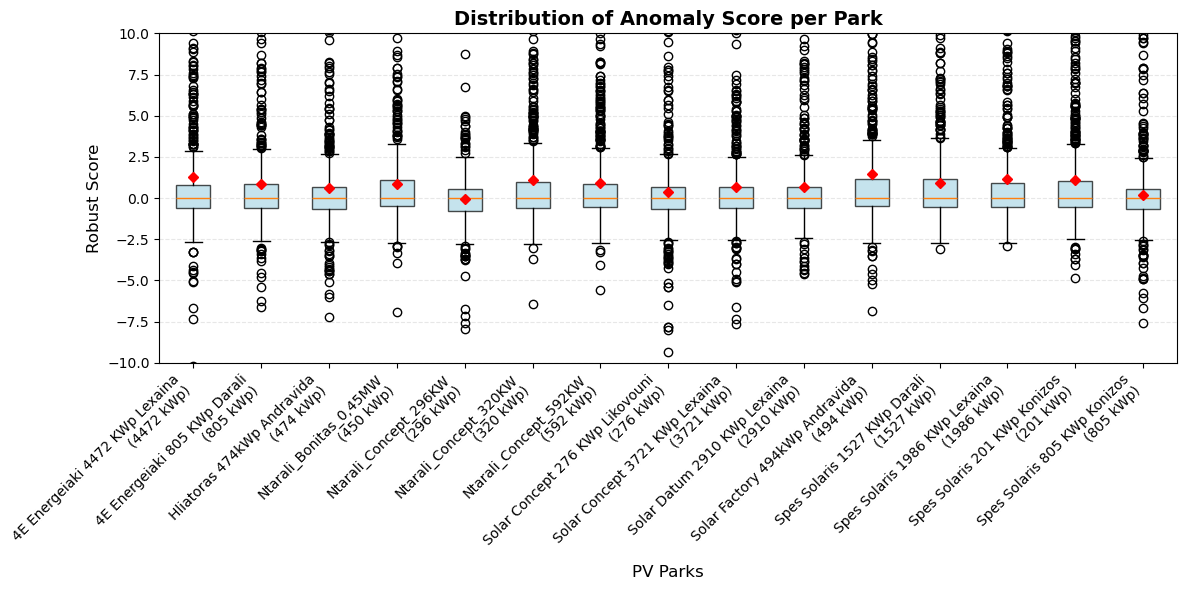

C:\Users\nbesiridis\AppData\Local\Temp\ipykernel_8660\362290088.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=labels, patch_artist=True, showmeans=True,


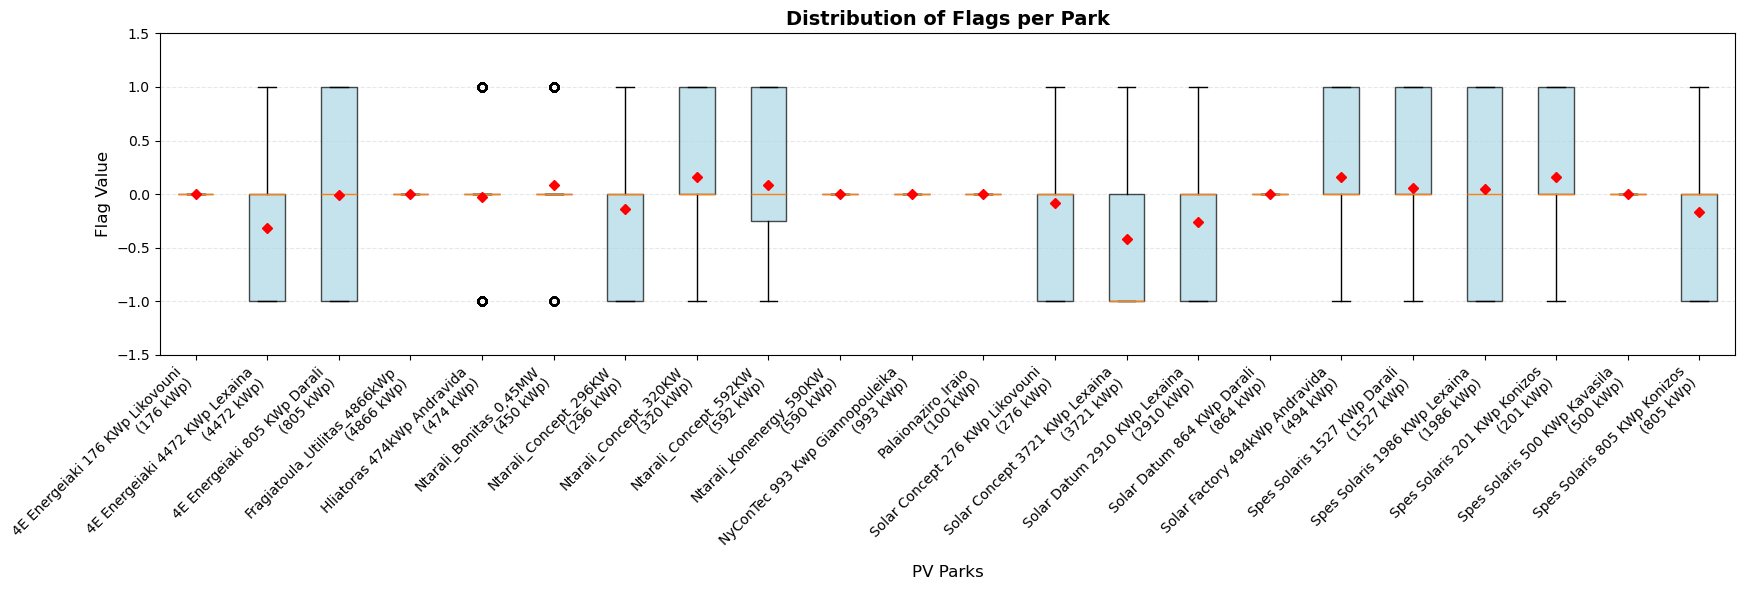

In [47]:
# Example usage of boxplot function
plot_boxplot(pi, "Distribution of PI_PVGIS per Park", ylabel="PI_PVGIS", ylim=(0.0, 2.0))
plot_boxplot(score, "Distribution of Anomaly Score per Park", ylabel="Robust Score", ylim=(-10, 10))
plot_boxplot(flag, "Distribution of Flags per Park", ylabel="Flag Value", ylim=(-1.5, 1.5))


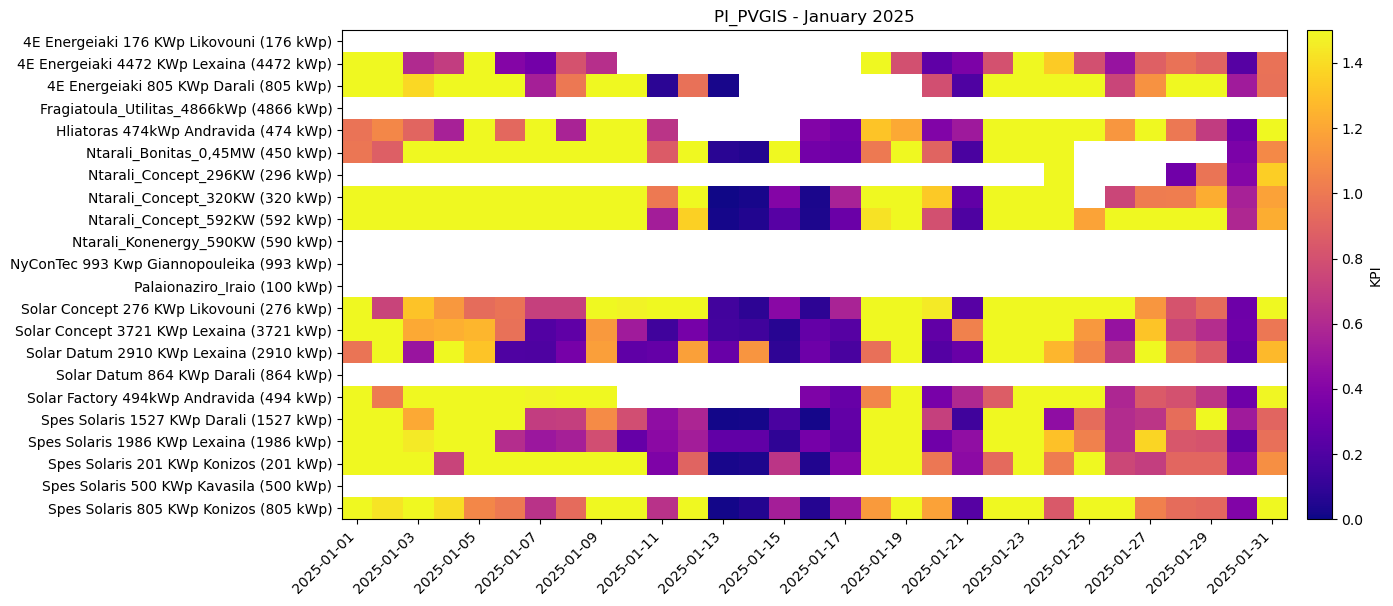

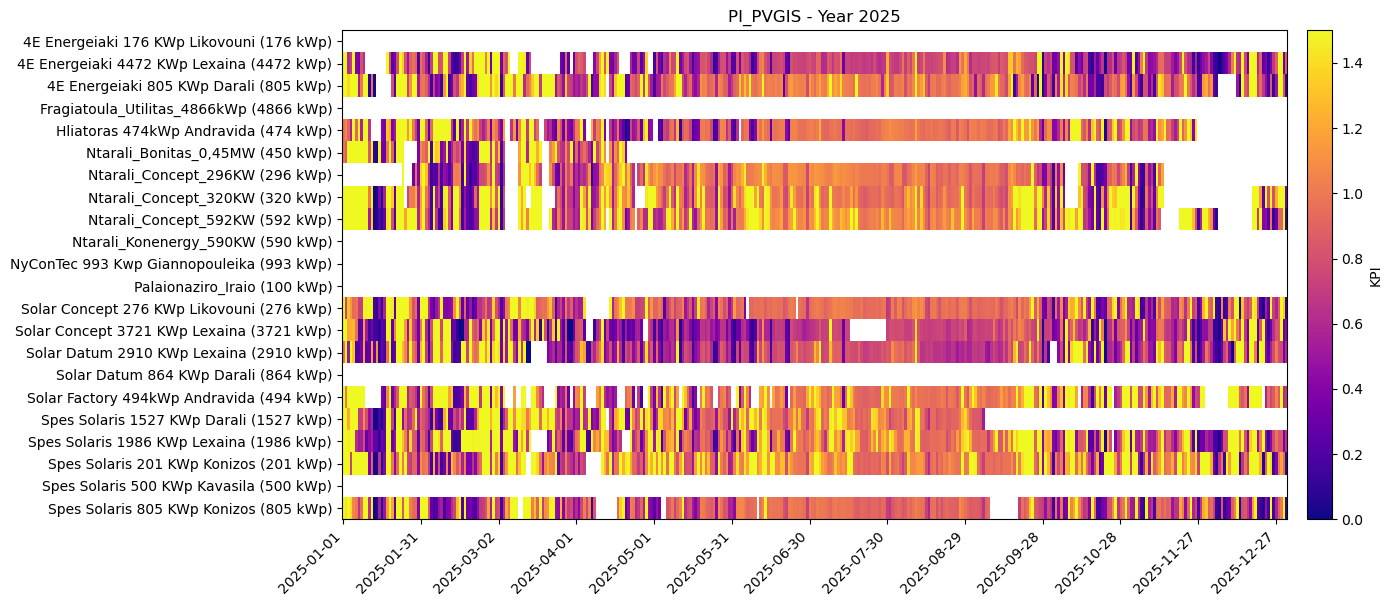

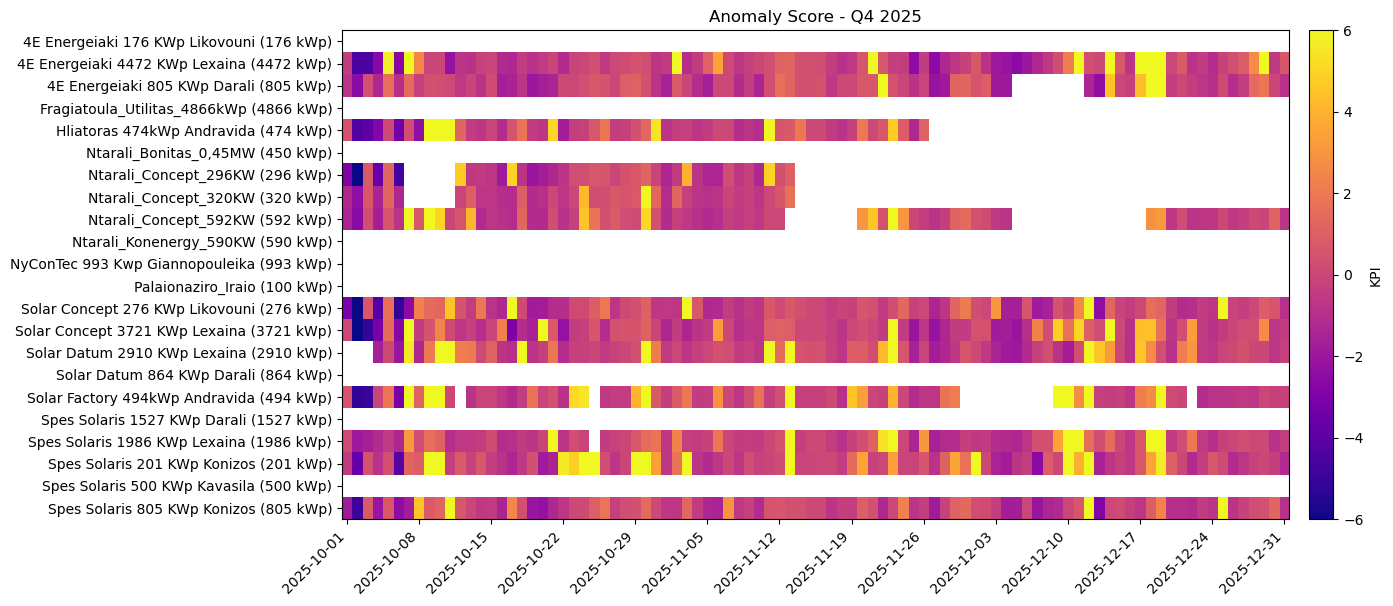

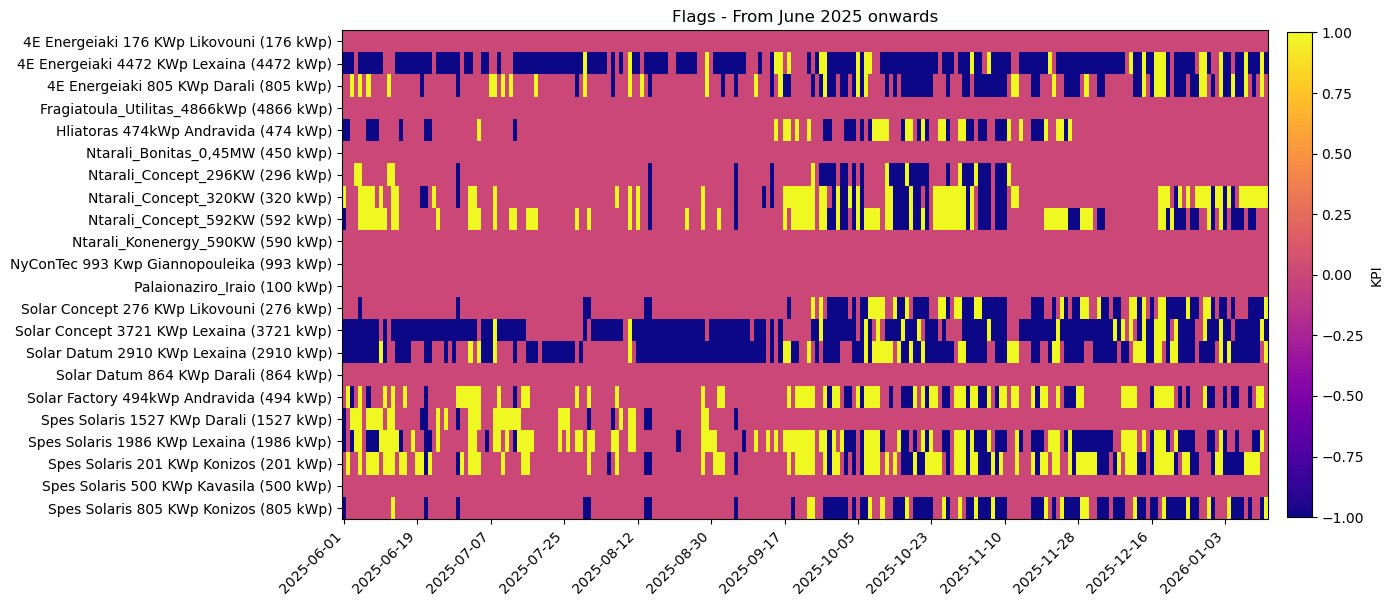

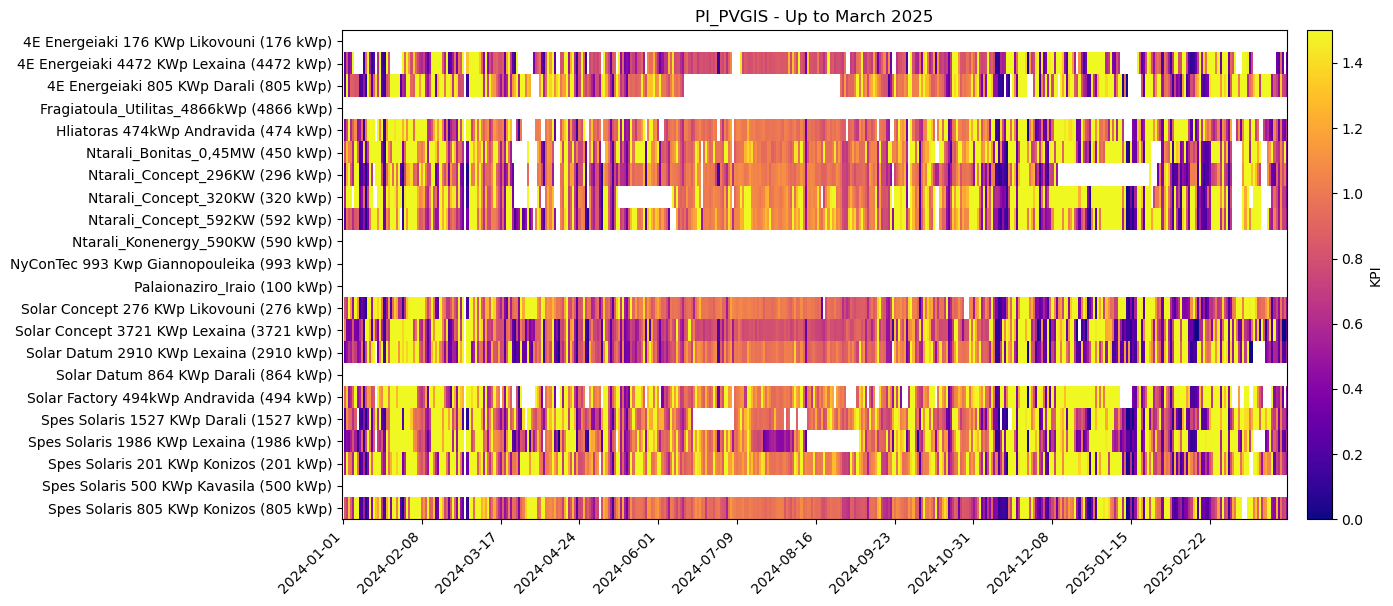

In [49]:
# Example: Filter heatmap to show only specific date ranges
# Show only January 2024
plot_heatmap(pi, "PI_PVGIS - January 2025", vmin=0.0, vmax=1.5, 
             start_date='2025-01-01', end_date='2025-01-31')

# Show only 2025 data
plot_heatmap(pi, "PI_PVGIS - Year 2025", vmin=0.0, vmax=1.5, 
             start_date='2025-01-01', end_date='2025-12-31')

# Show Q4 2024 (October-December)
plot_heatmap(score, "Anomaly Score - Q4 2025", vmin=-6, vmax=6,
             start_date='2025-10-01', end_date='2025-12-31')

# Show data from a specific date onwards
plot_heatmap(flag, "Flags - From June 2025 onwards", vmin=-1, vmax=1,
             start_date='2025-06-01')

# Show data up to a specific date
plot_heatmap(pi, "PI_PVGIS - Up to March 2025", vmin=0.0, vmax=1.5,
             end_date='2025-03-31')